# Statement of the problem:

Problem source: Statistical Rethinking Second Ediction Richard McElreath

The aim of the project is to predict the weight of urban foxes. The urban fox (Vulpes vulpes) is a successful exploiter of human habitat. Since urban foxes move in packs and defend territories, data on habitat quality and population density is also included. 


Data source: https://github.com/rmcelreath/rethinking/tree/master/data/foxes.csv

The data frame has five columns:

*   group: Number of the social group the individual fox belongs to
*   avgfood: The average amount of food available in the territory
*   groupsize: The number of foxes in the social group
*   area: Size of the territory
*   weight: Body weight of the individual fox


# Library import

In [1]:
from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import norm

# Reading data and preparing a model for predicting foxes weight

In [2]:
df = pd.read_csv('foxes.txt', sep=';')
df1 = df
df.head

<bound method NDFrame.head of      group  avgfood  groupsize  area  weight
0        1     0.37          2  1.09    5.02
1        1     0.37          2  1.09    2.84
2        2     0.53          2  2.05    5.33
3        2     0.53          2  2.05    6.07
4        3     0.49          2  2.12    5.85
..     ...      ...        ...   ...     ...
111     29     0.67          4  2.75    4.81
112     29     0.67          4  2.75    3.94
113     30     0.41          3  1.91    3.16
114     30     0.41          3  1.91    2.78
115     30     0.41          3  1.91    3.86

[116 rows x 5 columns]>

In [3]:
df.describe()

,group,avgfood,groupsize,area,weight
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,17.206897,0.751724,4.344828,3.169138,4.529655
std,8.002736,0.198316,1.538511,0.928354,1.184023
min,1.000000,0.370000,2.000000,1.090000,1.920000
25%,11.750000,0.660000,3.000000,2.590000,3.720000
50%,18.000000,0.735000,4.000000,3.130000,4.420000
75%,24.000000,0.800000,5.000000,3.772500,5.375000
max,30.000000,1.210000,8.000000,5.070000,7.550000


In [4]:
df['sg']=df.groupsize-df.groupsize.mean()
df['sf']=df.avgfood-df.avgfood.mean()
df['sa']=df.area-df.area.mean()
df.head(100)

,group,avgfood,groupsize,area,weight,sg,sf,sa
0,1,0.37,2,1.09,5.02,-2.344828,-0.381724,-2.079138
1,1,0.37,2,1.09,2.84,-2.344828,-0.381724,-2.079138
2,2,0.53,2,2.05,5.33,-2.344828,-0.221724,-1.119138
3,2,0.53,2,2.05,6.07,-2.344828,-0.221724,-1.119138
4,3,0.49,2,2.12,5.85,-2.344828,-0.261724,-1.049138
...,...,...,...,...,...,...,...,...
95,26,0.78,5,3.92,4.65,0.655172,0.028276,0.750862
96,26,0.78,5,3.92,3.80,0.655172,0.028276,0.750862
97,26,0.78,5,3.92,3.41,0.655172,0.028276,0.750862
98,27,0.79,5,2.89,4.12,0.655172,0.038276,-0.279138


# Distribution of weight 

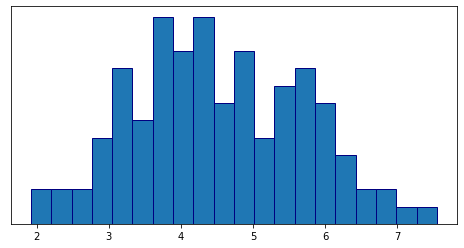

In [5]:
fig, axes = plt.subplots(figsize=(8, 4))
axes.hist(df["weight"], bins=20, edgecolor='navy')
axes.set_yticks([])
plt.show()

On histogram we see that weight distributions tends looks like Gaussian shape. Then we can describe weight distributiion as:$$ weight \sim\mathrm {Normal(\mu,\sigma)}$$

# Which variable are important for predicting fox body weight?

Correlaton matrix

In [6]:
df1.corr()

,group,avgfood,groupsize,area,weight,sg,sf,sa
group,1.000000,0.340845,0.400959,0.377773,-0.151900,0.400959,0.340845,0.377773
avgfood,0.340845,1.000000,0.901483,0.883104,-0.025039,0.901483,1.000000,0.883104
groupsize,0.400959,0.901483,1.000000,0.827594,-0.160994,1.000000,0.901483,0.827594
area,0.377773,0.883104,0.827594,1.000000,0.019477,0.827594,0.883104,1.000000
weight,-0.151900,-0.025039,-0.160994,0.019477,1.000000,-0.160994,-0.025039,0.019477
sg,0.400959,0.901483,1.000000,0.827594,-0.160994,1.000000,0.901483,0.827594
sf,0.340845,1.000000,0.901483,0.883104,-0.025039,0.901483,1.000000,0.883104
sa,0.377773,0.883104,0.827594,1.000000,0.019477,0.827594,0.883104,1.000000


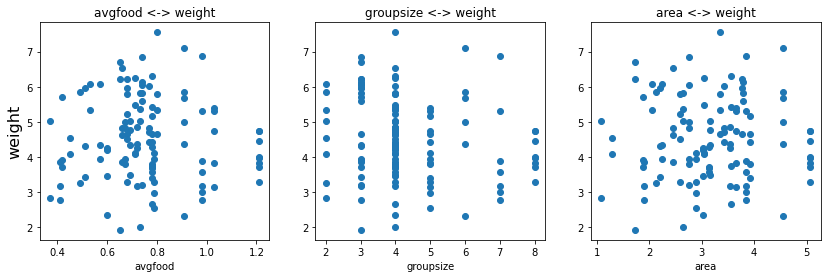

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].scatter(df["avgfood"], df["weight"]);
axes[0].set_ylabel("weight", fontsize=16);
axes[0].set_title("avgfood <-> weight")
axes[0].set_xlabel("avgfood");
axes[1].scatter(df["groupsize"], df["weight"]);
axes[1].set_title("groupsize <-> weight")
axes[1].set_xlabel("groupsize");
axes[2].scatter(df["area"], df["weight"]);
axes[2].set_xlabel("area");
axes[2].set_title("area <-> weight");

### Weight prior
  
Assuming $g$ as value of predictor "groupsize",model looks like: 
$$ weight \sim\mathrm {Normal(\mu,\sigma)} $$
$$ \mu = \alpha + \beta (g-\bar{g})$$
Next step is to estimate priors for $\alpha$ and $\beta$ paramteres.

For estimating $\alpha$ priors, need to start by getting assuming predictor value has no impact ($\beta = 0$). Knowing that urban foxes is the name given to Red Foxes living in the human city habitat, we can use weight values of normal red foxes. It can be justify this by saying that there was not enough time for Urban Foxes to evolutionary stray from their original species. 
Knowing that average red foxes weight around 5-7 kg and the ranges vary from 2.2 to 14 kg, it can be write prior as:
$$ \alpha \sim\mathrm {Normal(6,1.5)} $$

### Group size impact prior
Next step is to assume priors for our group size impact on wight parameter. Using simple deduction, i can come to a conclusion that bigger groups of animals will have lighter individuals. Main reason is: 
Bigger group -> Less food to split -> lighter individuals. 
I can support this saying that there is hierarchy in red foxes groups, so there is more internal fights, weaker individuals are even lighter and so on. I can assume priors for our group size parameter as: 
$$ \beta \sim\mathrm {Normal(-0.3,0.2)} $$

### Area size impact prior
Using deduction, I can predict that with bigger territory comes more sources of food, so it should impact weight positively. Like in group size estimation, my reason is: Bigger territory -> More sources of food -> Heavier individuals. Having that in mind, I write priors for area parameter as: 
$$ \beta \sim\mathrm {Normal(0.5,0.2)} $$

### Average amount of food in area
I can naturally assume that the more food is available in fox group territory, the more weight will have individuals belonging to this group. Knowing that I will assume our priors for avg food as: 
$$ \beta \sim\mathrm {Normal(0.5,0.2)} $$

## Model 1: Weight as linear function of group size

In [8]:
with open('model1_prio.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real Gs[N];
}

generated quantities {
  real<lower = 0> alpha=normal_rng(6,1.5);
  real beta = normal_rng(-0.3,0.2);
  real<lower = 0> sigma = normal_rng(0,3);

  real y_sim[N];
  for (k in 1:N) {
    y_sim[k] = normal_rng(beta*Gs[N]+alpha,sigma);
  }
}



In [9]:
model1_prior=CmdStanModel(stan_file='model1_prio.stan')
Gs = np.linspace(df["sg"].min(),df["sg"].max(),100)
data=dict(N=len(Gs),Gs=Gs)
sim1=model1_prior.sample(data=data,
                     fixed_param=True, 
                     iter_warmup=0, 
                     chains=1)

alpha1_sim=sim1.stan_variable('alpha')
beta1_sim=sim1.stan_variable('beta')
y1_sim=sim1.stan_variable('y_sim')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


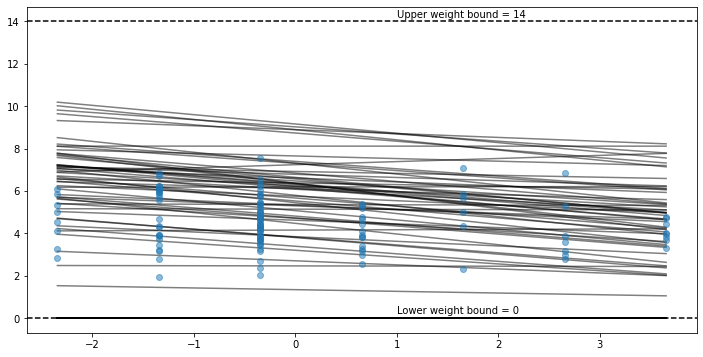

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(100):
    ax.plot(Gs,alpha1_sim[i]+beta1_sim[i]*Gs, alpha=0.5,zorder=0,color = 'black')
ax.scatter(df.sg,df.weight,alpha = 0.5)
ax.axhline(0, color = 'black', linestyle='--')
ax.text(1,0.2,'Lower weight bound = 0')

ax.axhline(14, color = 'black', linestyle='--')
ax.text(1,14.2,'Upper weight bound = 14')
plt.show()

## Model 2: Weight as linear function of area size

In [11]:
with open('model2_prio.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real As[N];
}

generated quantities {
  real<lower = 0> alpha=normal_rng(6,1.5);
  real beta = normal_rng(0.5,0.2);
  real<lower = 0> sigma = normal_rng(0,3);

  real y_sim[N];
  for (k in 1:N) {
    y_sim[k] = normal_rng(beta*As[N]+alpha,sigma);
  }
}



In [12]:
model2_prior=CmdStanModel(stan_file='model2_prio.stan')
As = np.linspace(df["sa"].min(),df["sa"].max(),100)
data=dict(N=len(As),As=As)
sim2=model2_prior.sample(data=data,
                     fixed_param=True, 
                     iter_warmup=0, 
                     chains=1)

alpha2_sim=sim2.stan_variable('alpha')
beta2_sim=sim2.stan_variable('beta')
y2_sim=sim2.stan_variable('y_sim')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


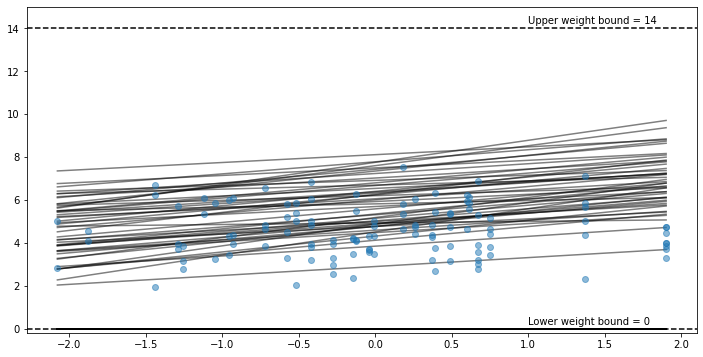

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(100):
    ax.plot(As,alpha2_sim[i]+beta2_sim[i]*As, alpha=0.5,zorder=0,color = 'black')
ax.scatter(df.sa,df.weight,alpha = 0.5)
ax.axhline(0, color = 'black', linestyle='--')
ax.text(1,0.2,'Lower weight bound = 0')

ax.axhline(14, color = 'black', linestyle='--')
ax.text(1,14.2,'Upper weight bound = 14')

ax.set_ylim([-0.2, 15])
plt.show()

## Model 3: Weight as linear function of average food

In [14]:
with open('model3_prio.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real Fs[N];
}

generated quantities {
  real<lower = 0> alpha=normal_rng(6,1.5);
  real beta = normal_rng(0.5,0.2);
  real<lower = 0> sigma = normal_rng(0,3);

  real y_sim[N];
  for (k in 1:N) {
    y_sim[k] = normal_rng(beta*Fs[N]+alpha,sigma);
  }
}



In [15]:
model3_prior=CmdStanModel(stan_file='model3_prio.stan')
Fs = np.linspace(df["sf"].min(),df["sf"].max(),100)
data=dict(N=len(Fs),Fs=Fs)
sim3=model3_prior.sample(data=data,
                     fixed_param=True, 
                     iter_warmup=0, 
                     chains=1)

alpha3_sim=sim3.stan_variable('alpha')
beta3_sim=sim3.stan_variable('beta')
y3_sim=sim3.stan_variable('y_sim')
sigma_sim=sim3.stan_variable('sigma')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


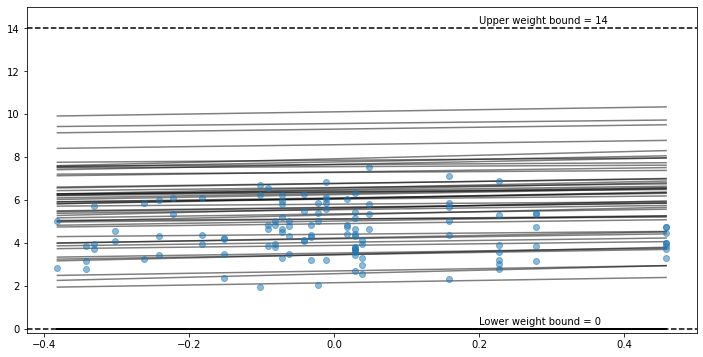

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(100):
    ax.plot(Fs,alpha3_sim[i]+beta3_sim[i]*Fs, alpha=0.5,zorder=0,color = 'black')
ax.scatter(df.sf,df.weight,alpha = 0.5)
ax.axhline(0, color = 'black', linestyle='--')
ax.text(0.2,0.2,'Lower weight bound = 0')

ax.axhline(14, color = 'black', linestyle='--')
ax.text(0.2,14.2,'Upper weight bound = 14')

ax.set_ylim([-0.2, 15])
plt.show()

After evaluating our priors with test above we can state that they are quite sensible.

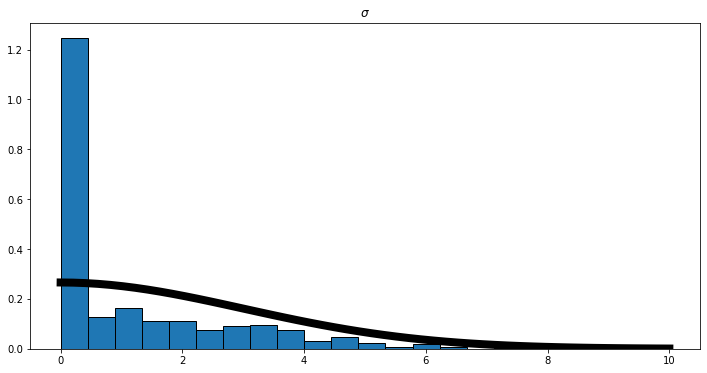

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sigma_sim,bins=20,edgecolor='black',density=True)
x=np.linspace(0,10)
y=stats.halfnorm.pdf(x,0,3)
ax.plot(x,y,color='black', linewidth=8)
ax.set_title('$\sigma$')

plt.show()

While area and avgfood show no consistent trends, groupsize seems to be negatively correlated to weight.

# Posterior and results
## Model 1: Weight as linear function of group size
Definition of the model : 
$$ weight \sim\mathrm {Normal(\mu,\sigma)} $$
$$ \mu = \alpha + \beta (g-\bar{g})$$
$$ \alpha \sim\mathrm {Normal(6,1.5)} $$
$$ \beta \sim\mathrm {Normal(-0.3,0.2)} $$
$$ \sigma \sim\mathrm {Half-Normal(0,3)} $$

In [18]:
with open('model1.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] Gs;
  real w[N];

  int GN;
  vector[GN] gen;
}

parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu;
  for (i in 1:N) {
    mu[i] = alpha + beta * (Gs[i]);
  }
}

model {
  alpha ~ normal(6,2);
  beta ~ normal(-0.3,0.2);
  sigma ~ normal(0,3);
  w ~ normal(mu, sigma);
}

generated quantities {
  vector[N] log_likelihood;
  real y_hat[N];

  for (i in 1:N) {
    log_likelihood[i] = normal_lpdf(w[i] | Gs[i], sigma);
    y_hat[i] = normal_rng(mu[i], sigma);
  }

  real w_sim[GN];
  for (i in 1:GN) {
    w_sim[i] = normal_rng(alpha + beta*(gen[i]), sigma);
  }

}



In [19]:
model1=CmdStanModel(stan_file='model1.stan')
d1 = df.sort_values(by=['sg'])
Gs = np.linspace(df["sg"].min(),df["sg"].max(),200)

data=dict(N=len(d1.weight), 
          w=d1.weight.values, 
          Gs=d1.sg.values, 
          GN=len(Gs),
          gen=Gs)


fit1=model1.sample(data=data)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [20]:
az.summary(fit1,var_names=['alpha','beta','sigma'],kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,4.527,0.111,4.311,4.723
beta,-0.145,0.069,-0.269,-0.011
sigma,1.186,0.080,1.034,1.332


## Model 2: Weight as linear function of area size
Definition of the model :
$$ weight \sim\mathrm {Normal(\mu,\sigma)} $$
$$ \mu = \alpha + \beta (a-\bar{a})$$
$$ \alpha \sim\mathrm {Normal(6,1.5)} $$
$$ \beta \sim\mathrm {Normal(0.5,0.2)} $$
$$ \sigma \sim\mathrm {Half-Normal(0,3)} $$

In [21]:
with open('model2.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] As;
  real w[N];

  int GN;
  vector[GN] gen;
}

parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu;
  for (i in 1:N) {
    mu[i] = alpha + beta * (As[i]);
  }
}

model {
  alpha ~ normal(6,2);
  beta ~ normal(0.5,0.2);
  sigma ~ normal(0,3);
  w ~ normal(mu, sigma);
}

generated quantities {
  real w_sim[GN];
  for (i in 1:GN) {
    w_sim[i] = normal_rng(alpha + beta*(gen[i]), sigma);
  }

  vector[N] log_likelihood;
  real y_hat[N];

  for (i in 1:N) {
    log_likelihood[i] = normal_lpdf(w[i] | As[i], sigma);
    y_hat[i] = normal_rng(mu[i], sigma);
  }
}



In [22]:
model2=CmdStanModel(stan_file='model2.stan')
d2 = df.sort_values(by=['sa'])
Ga = np.linspace(df["sa"].min(),df["sa"].max(),200)

data=dict(N=len(d2.weight), 
          w=d2.weight.values, 
          As=d2.sa.values, 
          GN=len(Ga),
          gen=Ga)


fit2=model2.sample(data=data)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [23]:
az.summary(fit2,var_names=['alpha','beta','sigma'],kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,4.537,0.111,4.325,4.732
beta,0.153,0.102,-0.031,0.352
sigma,1.206,0.083,1.058,1.363


## Model 3: Weight as linear function of average food
Definition of the model :
$$ weight \sim\mathrm {Normal(\mu,\sigma)} $$
$$ \mu = \alpha + \beta (f-\bar{f})$$
$$ \alpha \sim\mathrm {Normal(6,1.5)} $$
$$ \beta \sim\mathrm {Normal(0.5,0.2)} $$
$$ \sigma \sim\mathrm {Half-Normal(0,3)} $$

In [24]:
with open('model3.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] Fs;
  real w[N];

  int GN;
  vector[GN] gen;
}

parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu;
  for (i in 1:N) {
    mu[i] = alpha + beta * (Fs[i]);
  }
}

model {
  alpha ~ normal(6,2);
  beta ~ normal(-0.3,0.2);
  sigma ~ normal(0,3);
  w ~ normal(mu, sigma);
}

generated quantities {
  real w_sim[GN];
  for (i in 1:GN) {
    w_sim[i] = normal_rng(alpha + beta*(gen[i]), sigma);
  }

  vector[N] log_likelihood;
  real y_hat[N];

  for (i in 1:N) {
    log_likelihood[i] = normal_lpdf(w[i] | Fs[i], sigma);
    y_hat[i] = normal_rng(mu[i], sigma);
  }
}



In [25]:
model3=CmdStanModel(stan_file='model3.stan')
d3 = df.sort_values(by=['sf'])
Gf = np.linspace(df["sf"].min(),df["sf"].max(),200)

data=dict(N=len(d3.weight), 
          w=d3.weight.values, 
          Fs=d3.sf.values, 
          GN=len(Gf),
          gen=Gf)


fit3=model3.sample(data=data)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [26]:
az.summary(fit3,var_names=['alpha','beta','sigma'],kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,4.535,0.110,4.342,4.747
beta,-0.281,0.187,-0.622,0.074
sigma,1.196,0.081,1.045,1.344


# Results visualization

### Average amount of food in area
I assume that the more food there is in an area the more weight individuals in that area will have. Given this assumption, we can assume the priors for avrage food as: 
$$ \beta \sim\mathrm {Normal(0.5,0.2)} $$

C:\Users\Wiola\AppData\Local\Temp\ipykernel_256\502863414.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_w = az.hdi(h_sim, 0.89)
C:\Users\Wiola\AppData\Local\Temp\ipykernel_256\502863414.py:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_mu = az.hdi(mu_fit, 0.89)
C:\Users\Wiola\AppData\Local\Temp\ipykernel_256\502863414.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_w = az.hdi(h_sim, 0.89)
C:\Users\Wiola\AppData\Local\Temp\ipykernel_256\502863414.py:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_mu = az.hd

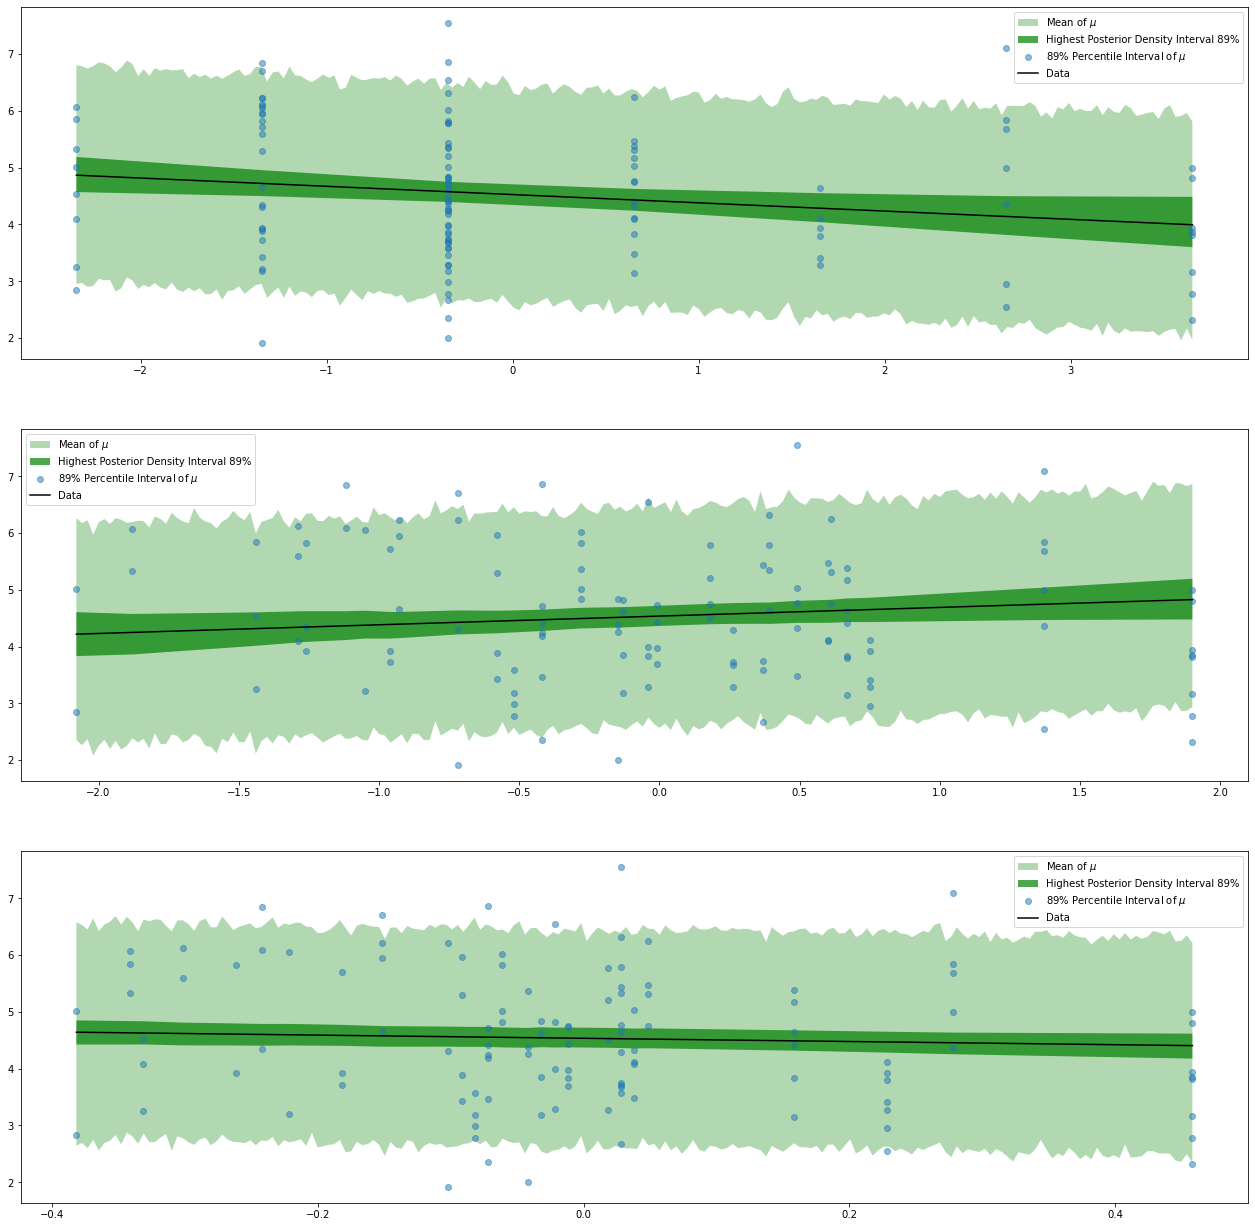

In [27]:
fig, axes = plt.subplots(3,1, figsize=(22, 22),sharey=True)
axr= axes.ravel()
fit = [fit1, fit2, fit3]
sq = [Gs, Ga, Gf]
sq2 = [d1.sg.values, d2.sa.values, d3.sf.values]
for i in range(3):
    alpha_fit=fit[i].stan_variable('alpha')
    beta_fit=fit[i].stan_variable('beta')
    mu_fit=fit[i].stan_variable('mu')
    h_sim=fit[i].stan_variable('w_sim')
    hdi_w = az.hdi(h_sim, 0.89)
    hdi_mu = az.hdi(mu_fit, 0.89)

    axr[i].fill_between(sq[i], hdi_w[:,0], hdi_w[:,1], facecolor='green', alpha=0.3);
    axr[i].fill_between(sq2[i], hdi_mu[:,0], hdi_mu[:,1], facecolor='green', alpha=0.7);
    axr[i].scatter(sq2[i], df.weight, alpha=0.5)
    axr[i].plot(sq2[i], np.mean(mu_fit,0), color='black')
    axr[i].legend(['Mean of $\mu$', 'Highest Posterior Density Interval 89%', '89% Percentile Interval of $\mu$', 'Data'])
plt.show()

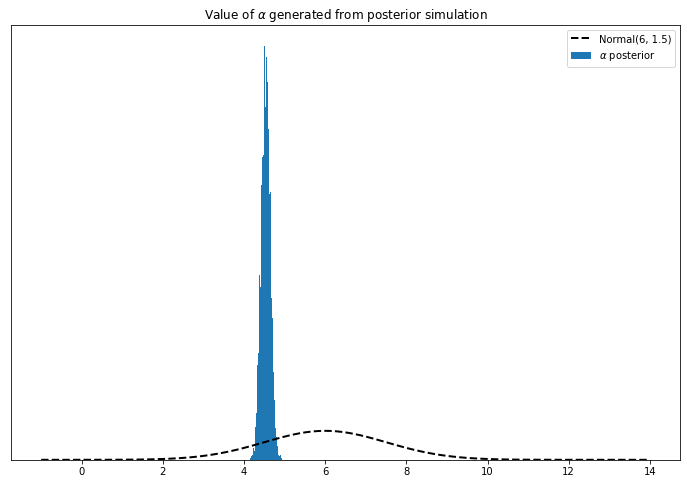

In [28]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))
ax.hist(fit[1].stan_variable('alpha'), bins=50, density=True)
x=np.linspace(-1,14,100)
ax.set_title(r'Value of $\alpha$ generated from posterior simulation')
ax.plot(x, stats.norm.pdf(x, 6, 1.5), color='black', linestyle='dashed', linewidth=2)
ax.legend(['Normal(6, 1.5)',r'$\alpha$ posterior'])
ax.set_yticks([]);

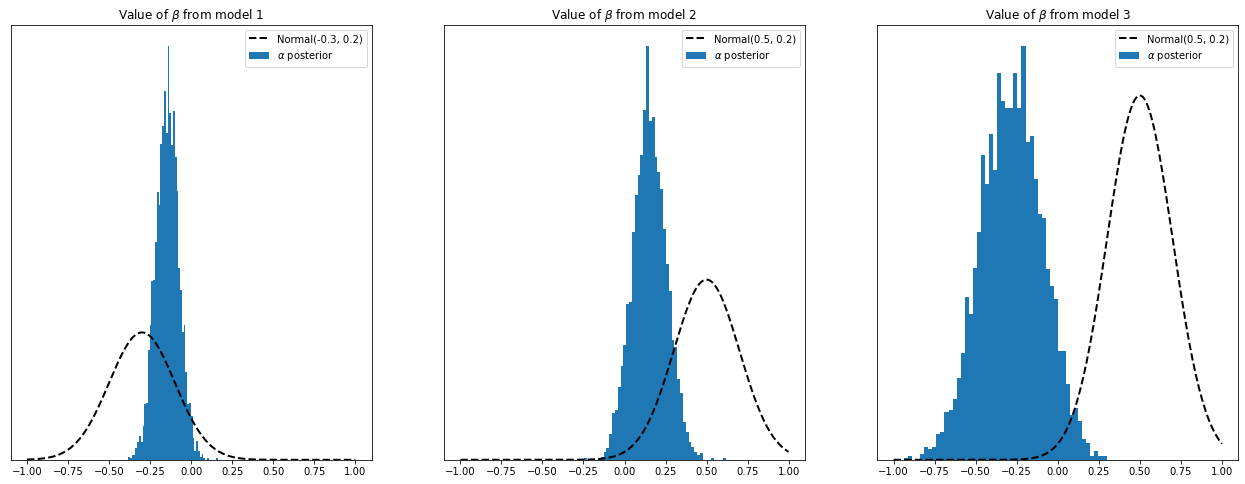

In [29]:
fig, ax = plt.subplots(1,3, figsize=(22, 8))
mu_v = [-0.3, 0.5, 0.5]
sig_v = [0.2, 0.2, 0.2]
for i in range(3):
    ax[i].hist(fit[i].stan_variable('beta'), bins=50, density=True)
    x=np.linspace(-1,1,200)
    ax[i].set_title(r'Value of $\beta$ from model '+str(i+1))
    ax[i].plot(x, stats.norm.pdf(x, mu_v[i], sig_v[i]), color='black', linestyle='dashed', linewidth=2)
    ax[i].legend(['Normal('+str(mu_v[i])+', '+str(sig_v[i])+')',r'$\alpha$ posterior'])
    ax[i].set_yticks([]);

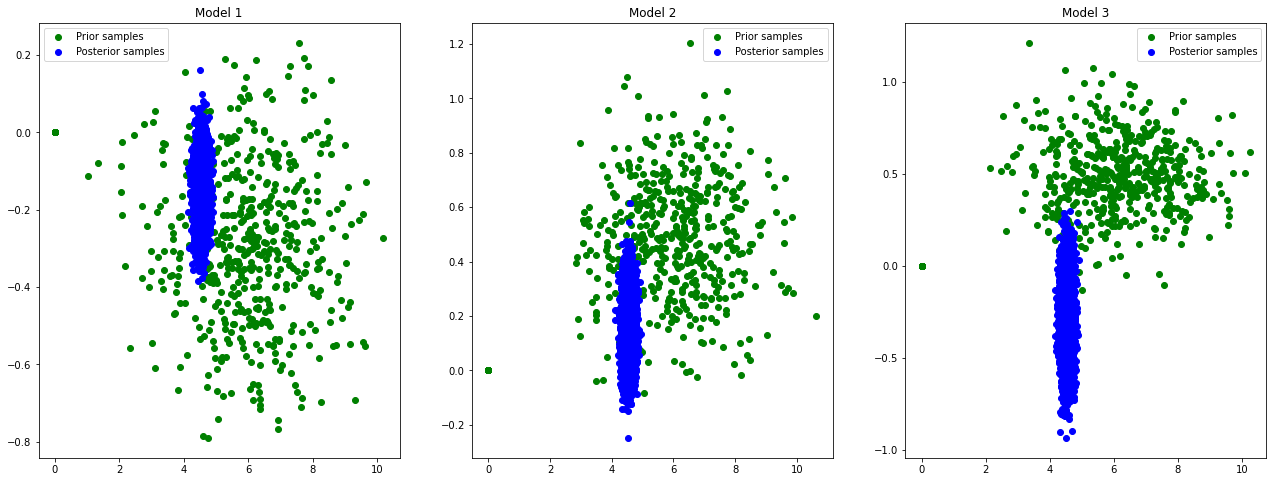

In [30]:
fig, ax = plt.subplots(1,3, figsize=(22, 8))
alfa_v = [alpha1_sim, alpha2_sim, alpha3_sim]
beta_v = [beta1_sim, beta2_sim, beta3_sim]
for i in range(3):
    ax[i].scatter(alfa_v[i], beta_v[i], color='green')
    x=np.linspace(-1,1,200)
    ax[i].set_title(r'Model '+str(i+1))
    ax[i].scatter(fit[i].stan_variable('alpha'), fit[i].stan_variable('beta'), color='blue')
    ax[i].legend(['Prior samples',r'Posterior samples'])

## Compare models using LOO
Leave-One-Out Cross-Validation or K-fold Cross-Validation is another quite universal approach for model selection. However, to implement K-fold cross-validation we need to partition the data repeatedly and fit the model on every partition. It can be very time consumming (computation time increase roughly as a factor of K). 

In [31]:
mod_1 = az.from_cmdstanpy( posterior=fit1,
                           log_likelihood='log_likelihood',
                           posterior_predictive='y_hat',
                           observed_data={'w':df['weight'].values} )

mod_2 = az.from_cmdstanpy( posterior=fit2,
                           log_likelihood='log_likelihood',
                           posterior_predictive='y_hat',
                           observed_data={'w':df['weight'].values} )

mod_3 = az.from_cmdstanpy( posterior=fit3,
                           log_likelihood='log_likelihood',
                           posterior_predictive='y_hat',
                           observed_data={'w':df['weight'].values} )

In [32]:
if not hasattr(mod_1, "log_likelihood"):
    print("log likelihood not found in inference data object")

In [33]:
compare_dict = {"model1": mod_1, "model2": mod_2, "model3": mod_3}
az.compare(compare_dict)

c:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:812: UserWarning: 

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model3,0,-1111.759093,145.340900,0.000000,0.381788,50.609449,0.000000,True,log
model2,1,-1139.491306,164.042736,27.732213,0.295691,62.319166,74.426548,True,log
model1,2,-1301.731344,234.731090,189.972251,0.322522,85.208443,97.021543,True,log


c:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:812: UserWarning: 

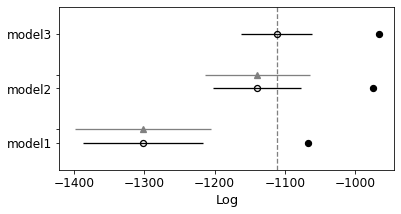

In [34]:
az.plot_compare(az.compare(compare_dict))
plt.show()

The analysis did not show a clear winner. For each model, the warning column takes the value True. This value indicates that the calculations may not be reliable. In addition, the column se (standard error) shows a huge value which makes us suspect that the models are not correct. 

In the chart above the empty circle represents the values of LOO and the black error bars associated with them are the values of the standard deviation of LOO. The value of the highest LOO, i.e the best estimated model, is also indicated with a vertical dashed grey line to ease comparison with other LOO values. For all models except the top-ranked one we also get a triangle indicating the value of the difference of LOO between that model and the top model and a grey errobar indicating the standard error of the differences between the top-ranked LOO and LOO for each model.

# Compare models using WAIC

The Widely Applicable Information Criterion (WAIC) can be used to calculate the goodness-of-fit of a model using numerical techniques

In [35]:
dfwaic = az.compare(compare_dict, ic="WAIC")
dfwaic

c:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model3,0,-1110.761798,144.343605,0.000000,0.381619,50.527466,0.000000,True,log
model2,1,-1142.465572,167.017002,31.703774,0.295356,62.975739,74.876773,True,log
model1,2,-1299.421039,232.420785,188.659242,0.323025,85.173160,96.959295,True,log


c:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


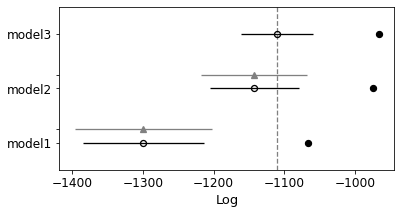

In [36]:
az.plot_compare(az.compare(compare_dict, ic="WAIC"))
plt.show()

As above, the analysis did not show a clear winner. For each model, the warning column takes the value True. Also a large standard error. Data from WAIC and LOO analysis have similar values. 

# Conclusion
The WAIC and PSIS-LOO analyses did not identify the best model. In both cases, the analyses indicated a rank of 0 for model number 3 . However, it cannot be considered a reliable winner because there are warnings and therefore the LOO-WAIC calculations for this model may not be reliable.


Although the WAIC and LOO analysis did not show a clear winner I believe that the best model is model 3. Compared to other models, it has a large lower standard error.